In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 100% !important; }</style>"))

# Naive Bayes Classifier
We use the Naive Bayes Classifier to determine whether a job posting is fraudulent or real.

In [2]:
import pandas as pd
import numpy as np

In [3]:
dataset = pd.read_excel('Job_Postings(clean).xlsx')

## The features and the target class of the dataset

In [4]:
features = dataset.columns[1:dataset.columns.shape[0]-1].to_numpy()
print('features:', '\n', features, '\n')

target_class = dataset.columns[dataset.columns.shape[0]-1]
print('target class:', '\n', target_class)

features: 
 ['job_id' 'title' 'location' 'department' 'salary_range' 'company_profile'
 'description' 'requirements' 'benefits' 'telecommuting'
 'has_company_logo' 'has_questions' 'employment_type'
 'required_experience' 'required_education' 'industry' 'function'] 

target class: 
 fraudulent


## Split the dataset:

In [5]:
training_data = dataset.loc[:10728]
validation_data = dataset.loc[10729:16450]
test_data = dataset.loc[16451:]

print("Training data: ",training_data.shape)
print("Validation data: ",validation_data.shape)
print("Test data: ",test_data.shape,'\n')

print('training data example item:','\n\n', training_data.loc[0])

Training data:  (10729, 19)
Validation data:  (5722, 19)
Test data:  (1429, 19) 

training data example item: 

 Unnamed: 0                                                             0
job_id                                                                 1
title                                                   marketing intern
location                                                   us,ny,newyork
department                                                     marketing
salary_range                                                     missing
company_profile        were food52 and weve created a groundbreaking ...
description            food52 a fastgrowing james beard awardwinning ...
requirements           experience with content management systems a m...
benefits                                                         missing
telecommuting                                                          0
has_company_logo                                                       1
has_questio

## Compute Probabilities:

### 1. Compute Prior Probabilities

In [6]:
class_labels, class_labels_counts = np.unique(training_data['fraudulent'], return_counts=True)

prior_prob_real = class_labels_counts[0] / np.sum(class_labels_counts)
prior_prob_fraud = 1 - prior_prob_real

print('Class labels: ', class_labels)
print("Number of real job posts: ",class_labels_counts[0])
print("Number of fraudulent job posts: ",class_labels_counts[1],"\n")
print('Prior probability job post is REAL: ', prior_prob_real)
print('Prior probability job post is FRAUDULENT: ', prior_prob_fraud)

Class labels:  [0 1]
Number of real job posts:  10268
Number of fraudulent job posts:  461 

Prior probability job post is REAL:  0.9570323422499767
Prior probability job post is FRAUDULENT:  0.042967657750023314


### 2. Class Conditional Model:

#### HELPER FUNCTIONS
- Compute fraudulent and real counts of each feature

In [7]:
def compute_counts(class_labels, feature_full_data, feature_unique_data):
    
    # Get index of the classes
    real_index = np.where(class_labels == 0)[0]
    fraud_index = np.where(class_labels == 1)[0]
    
    # Get the real and fraudulent features
    feature_real = feature_full_data[real_index]
    feature_fraud = feature_full_data[fraud_index]
    
    # Get unique real and fraudulent features
    unique_feature_real, real_counts =  np.unique(feature_real ,return_counts=True)
    unique_feature_fraud, fraud_counts =  np.unique(feature_fraud ,return_counts=True)
    
    # Get the indices
    real_bool = np.isin(feature_unique_data,unique_feature_real)
    real_index = np.where(real_bool == True)[0]
    fraud_bool = np.isin(feature_unique_data,unique_feature_fraud)
    fraud_index = np.where(fraud_bool == True)[0]
        
    # Initialise counts
    unique_real_counts = np.zeros(feature_unique_data.shape)
    unique_fraud_counts = np.zeros(feature_unique_data.shape)
    
    # create unique counts
    unique_real_counts[real_index] = real_counts
    unique_fraud_counts[fraud_index] = fraud_counts
    
    # create the pandas object
    result_object = pd.DataFrame({'Real':unique_real_counts,
                                 'Fraudulent':unique_fraud_counts},
                                 index =feature_unique_data )
    return result_object

- Compute fraudulent and real counts of each the descriptive features(with long text)

In [8]:
def count_text(class_labels,feature_data):
    
    # Get index of the classes
    real_class_index = np.where(class_labels == 0)[0]
    fraud_class_index = np.where(class_labels == 1)[0]
    
    # Get the real and fraudulent features
    feature_real = feature_data[real_class_index].str.split()
    feature_fraud = feature_data[fraud_class_index].str.split()
    
    # Create text that convey a particular tone (fraud/real)
    real_text = feature_real.explode().to_numpy()
    fraud_text = feature_fraud.explode().to_numpy()
    
    # Find unique words and word counts
    unique_real_text,real_counts = np.unique(real_text,return_counts = True)
    unique_fraud_text,fraud_counts = np.unique(fraud_text,return_counts = True)
    print("Real Counts:",real_counts.shape)
    print("Fraud Counts:",fraud_counts.shape)
    
    # Find all unique words
    temp_words = np.append(unique_real_text,unique_fraud_text)
    all_unique_words = np.unique(temp_words)
    tot_all_unique_words = len(all_unique_words)
    
    
    # Get the indices of real or fraudelent words in all unique words
    real_bool = np.isin(all_unique_words,unique_real_text)
    real_index = np.where(real_bool == True)[0]
    fraud_bool = np.isin(all_unique_words,unique_fraud_text)
    fraud_index = np.where(fraud_bool == True)[0]
#     print(fraud_index)
        
    # Initialise the unique counts
    unique_real_counts = np.zeros(all_unique_words.shape)
    unique_fraud_counts = np.zeros(all_unique_words.shape)
#     print("Unique real counts:",unique_real_counts.shape)
#     print("Unique fraud counts:",unique_fraud_counts.shape)
    
    # Assign the counts to their repective indices
    unique_real_counts[real_index] = real_counts
    unique_fraud_counts[fraud_index] = fraud_counts
    
    # Make pandas object to store this data object
    result_object = pd.DataFrame({'Real':unique_real_counts,
                                 'Fraudulent':unique_fraud_counts},
                                 index =all_unique_words )
    return result_object

-  Compute probabilities 

In [9]:
def compute_probabilities(feature_values_fraud_counts):
    
    #Temporary values
    fraud_arr = feature_values_fraud_counts['Fraudulent']
    real_arr = feature_values_fraud_counts['Real']

    
    # Init the probabilities
    prob_real = np.zeros(feature_values_fraud_counts.shape[0])
    prob_fraud = np.zeros(feature_values_fraud_counts.shape[0])
    
    # (1)Find index of zero values for  laplacian smoothing
    fraud_zero_index = np.where( fraud_arr == 0)[0]
    real_zero_index = np.where(real_arr == 0)[0]
    
    # apply laplacian by adding a fake datapoint count to both counts of each class label
    feature_value_freq_laplacian_real = np.add(fraud_arr[real_zero_index],real_arr[real_zero_index])+2
    feature_value_freq_laplacian_fraud = np.add(fraud_arr[fraud_zero_index],real_arr[fraud_zero_index])+2
    #Calculate probabilites
    prob_real[real_zero_index] = (real_arr[real_zero_index]+1)/feature_value_freq_laplacian_real
    prob_fraud[fraud_zero_index] = (fraud_arr[fraud_zero_index]+1)/feature_value_freq_laplacian_fraud
    
    # (2)Find index of non-zero values
    fraud_nonzero_index = np.where( fraud_arr != 0)[0]
    real_nonzero_index = np.where(real_arr != 0)[0]
    
    #Calculate probabilites
    feature_value_freq_real = np.add(fraud_arr[real_nonzero_index],real_arr[real_nonzero_index])
    feature_value_freq_fraud = np.add(fraud_arr[fraud_nonzero_index],real_arr[fraud_nonzero_index])
    
    prob_real[real_nonzero_index] = real_arr[real_nonzero_index]/feature_value_freq_real
    prob_fraud[fraud_nonzero_index] = fraud_arr[fraud_nonzero_index]/feature_value_freq_fraud

    
    # Create pandas object
    result_object = pd.DataFrame({'RealProb':prob_real,
                                 'FraudulentProb':prob_fraud},
                                 index =feature_values_fraud_counts.index)
    return result_object

### 3. Compute Counts

#### (1) Title Feature
Compute fraud and real counts of each unique title with respect to the class labels

In [10]:
training_data_titles = training_data['title']
unique_titles = np.unique(training_data_titles)
print("No of unique titles:",unique_titles.shape)
title_counts = compute_counts(training_data['fraudulent'], training_data_titles, unique_titles)
print(title_counts.head())

No of unique titles: (6921,)
                                                    Real  Fraudulent
$950/week truck drivers needed                       1.0         0.0
$950/week. truck drivers needed                      1.0         0.0
(assistant) accountant                               1.0         0.0
(internship) communication / e-marketing assistant   1.0         0.0
(internship) pr / event manager assistant            1.0         0.0


#### (2) Location feature
Compute fraud and real counts of each unique location with respect to the class labels

In [11]:
training_data_locations = training_data['location']
unique_locations = np.unique(training_data_locations)
location_counts = compute_counts(training_data['fraudulent'], training_data_locations, unique_locations)
print(location_counts.head())

                         Real  Fraudulent
ae                        3.0         0.0
ae,az,abudhabi            1.0         0.0
ae,du                     4.0         0.0
ae,du,dubai              16.0         0.0
ae,du,dubaiinternetcity   2.0         0.0


#### (3) Department feature
Compute fraud and real counts of each unique department with respect to the class labels

In [12]:
training_data_departments = training_data['department']
unique_departments = np.unique(training_data_departments)
department_counts = compute_counts(training_data['fraudulent'], training_data_departments, unique_departments)
print(department_counts.head())

                             Real  Fraudulent
\tcorporate shared services   0.0         1.0
(consultant)                  1.0         0.0
.net development              1.0         0.0
0                             1.0         0.0
1221                          0.0         1.0


#### (4) Salary Range feature
Compute fraud and real counts of each unique value in salary_range feature with respect to the class labels

In [13]:
training_data_salary_ranges = training_data['salary_range']
unique_salary_ranges = np.unique(training_data_salary_ranges)
salary_range_counts = compute_counts(training_data['fraudulent'], training_data_salary_ranges, unique_salary_ranges)
print(salary_range_counts.head())

          Real  Fraudulent
0-0       76.0         0.0
0-1        1.0         0.0
0-1000     2.0         0.0
0-100000   3.0         0.0
0-110406   1.0         0.0


#### (5) Telecommuting feature
Compute fraud and real counts of each unique value in telecommuting feature with respect to the class labels

In [14]:
training_data_telecommuting = training_data['telecommuting']
unique_telecommuting = np.unique(training_data['telecommuting'])
telecommuting_counts = compute_counts(training_data['fraudulent'], training_data_telecommuting, unique_telecommuting)
print(telecommuting_counts.head())

     Real  Fraudulent
0  9831.0       421.0
1   437.0        40.0


#### (6) Company logo feature
Compute fraud and real counts of each unique value in has_company_logo feature with respect to the class labels

In [15]:
training_data_company_logo = training_data['has_company_logo']
unique_company_logo = np.unique(training_data_company_logo)
company_logo_counts = compute_counts(training_data['fraudulent'], training_data_company_logo, unique_company_logo)
print(company_logo_counts.head())

     Real  Fraudulent
0  1873.0       275.0
1  8395.0       186.0


#### (7) Questions feature
Compute fraud and real counts of each unique value in has_questions feature with respect to the class labels

In [16]:
training_data_questions = training_data['has_questions']
unique_questions = np.unique(training_data_questions)
questions_counts = compute_counts(training_data['fraudulent'], training_data_questions, unique_questions)
print(questions_counts.head())

     Real  Fraudulent
0  4702.0       310.0
1  5566.0       151.0


#### (8) Employment Type feature
Compute fraud and real counts of each unique employment_type feature value with respect to the class labels

In [17]:
training_data_employment_type = training_data['employment_type']
unique_employment_type = np.unique(training_data_employment_type)
employment_type_counts = compute_counts(training_data['fraudulent'], training_data_employment_type, unique_employment_type)
print(employment_type_counts.head())

             Real  Fraudulent
contract   1040.0        26.0
full-time  6405.0       289.0
missing    2098.0       124.0
other       128.0         4.0
part-time   445.0        17.0


#### (9) Required Experience feature
Compute fraud and real counts of each unique required_experience feature value with respect to the class labels

In [18]:
training_data_required_experience = training_data['required_experience']
unique_required_experience = np.unique(training_data_required_experience)
required_experience_counts = compute_counts(training_data['fraudulent'], training_data_required_experience, unique_required_experience)
print(required_experience_counts.head())

               Real  Fraudulent
associate    1379.0        24.0
director      232.0        11.0
entry level  1610.0        91.0
executive      80.0         8.0
internship    230.0         6.0


#### (10) Required Education feature
Compute fraud and real counts of each unique required_education feature value with respect to the class labels

In [19]:
training_data_required_education = training_data['required_education']
unique_required_education = np.unique(training_data_required_education)
required_education_counts = compute_counts(training_data['fraudulent'], training_data_required_education, unique_required_education)
print(required_education_counts.head())

                             Real  Fraudulent
associate degree            148.0         5.0
bachelor's degree          3192.0        62.0
certification                80.0        11.0
doctorate                    20.0         0.0
high school or equivalent  1158.0        98.0


#### (11) Industry feature
Compute fraud and real counts of each unique industry feature value with respect to the class labels

In [20]:
training_data_industry = training_data['industry']
unique_industry = np.unique(training_data_industry)
industry_counts = compute_counts(training_data['fraudulent'], training_data_industry, unique_industry)
print(industry_counts.head())

                         Real  Fraudulent
accounting               62.0        25.0
airlines/aviation        26.0         0.0
animation                 2.0         0.0
apparel & fashion        49.0         0.0
architecture & planning   6.0         0.0


#### (12) Function feature
Compute fraud and real counts of each unique function feature value with respect to the class labels

In [21]:
training_data_function = training_data['function']
unique_function = np.unique(training_data_function)
function_counts = compute_counts(training_data['fraudulent'], training_data_function, unique_function)
print(function_counts.head())

                      Real  Fraudulent
accounting/auditing  130.0         8.0
administrative       347.0        51.0
advertising           59.0         3.0
art/creative          72.0         0.0
business analyst      45.0         1.0


### Sentiment analysis features

#### (14) Company profile feature
Compute fraud and real counts of each unique word in company profile feature value with respect to the class labels

In [22]:
training_data_company_profile = training_data['company_profile']
company_profile_counts = count_text(training_data['fraudulent'],training_data_company_profile)
print(company_profile_counts.head())

Real Counts: (17787,)
Fraud Counts: (1242,)
                                                    Real  Fraudulent
0                                                   14.0         0.0
000                                                 28.0         0.0
00phone_21b21d2fe8e914fb2fc8e5e48952a8b26469b7d...   1.0         0.0
00phone_c61d5134628fb74682f7394c6bd4e383753eb89...   1.0         0.0
02                                                   2.0         0.0


#### (14) Description feature
Compute fraud and real counts of each unique word in description feature value with respect to the class labels

In [23]:
training_data_description = training_data['description']
description_counts = count_text(training_data['fraudulent'],training_data_description)
print(description_counts.head())

Real Counts: (78015,)
Fraud Counts: (8432,)
               Real  Fraudulent
0              54.0         1.0
000             8.0         2.0
004contact      1.0         0.0
00592duration   2.0         0.0
01761           1.0         0.0


#### (15) Requirements feature
Compute fraud and real counts of each unique word in requirements feature value with respect to the class labels

In [24]:
training_data_requirements = training_data['requirements'].astype(np.unicode)
requirements_counts = count_text(training_data['fraudulent'],training_data_requirements)
print(requirements_counts.head())

Real Counts: (54525,)
Fraud Counts: (5313,)
         Real  Fraudulent
0        51.0         0.0
0062834   1.0         0.0
01        1.0         0.0
01252     1.0         0.0
02        2.0         0.0


#### (16) Benefits feature
Compute fraud and real counts of each unique word in benefits feature value with respect to the class labels

In [25]:
training_data_benefits = training_data['benefits'].astype(np.unicode)
benefits_counts = count_text(training_data['fraudulent'],training_data_benefits)
print(benefits_counts.head())

Real Counts: (17613,)
Fraud Counts: (1714,)
                Real  Fraudulent
0               19.0         0.0
000              4.0         1.0
0062953          1.0         0.0
01772724252job   1.0         0.0
025              4.0         0.0


### 4. Compute probabilities
Compute probabilities of each unique feature value with respect to the class labels

In [26]:
titles_prob = compute_probabilities(title_counts)
print(titles_prob.head())
locations_prob = compute_probabilities(location_counts)
departments_prob = compute_probabilities(department_counts)
salary_range_prob = compute_probabilities(salary_range_counts)
telecommuting_prob = compute_probabilities(telecommuting_counts)
company_logo_prob = compute_probabilities(company_logo_counts)
questions_prob = compute_probabilities(questions_counts)
employment_type_prob = compute_probabilities(employment_type_counts)
required_experience_prob = compute_probabilities(required_experience_counts)
required_education_prob = compute_probabilities(required_education_counts)
industry_prob = compute_probabilities(industry_counts)
functions_prob = compute_probabilities(function_counts)

# Sentiment probabilities
company_profile_prob = compute_probabilities(company_profile_counts)
description_prob = compute_probabilities(description_counts)
requirements_prob = compute_probabilities(requirements_counts)
benefits_prob = compute_probabilities(benefits_counts)

                                                    RealProb  FraudulentProb
$950/week truck drivers needed                           1.0        0.333333
$950/week. truck drivers needed                          1.0        0.333333
(assistant) accountant                                   1.0        0.333333
(internship) communication / e-marketing assistant       1.0        0.333333
(internship) pr / event manager assistant                1.0        0.333333


## Make an inference

### Helper Functions

In [46]:
all_probabilities = []
all_probabilities.append(titles_prob)
all_probabilities.append(locations_prob)
all_probabilities.append(departments_prob)
all_probabilities.append(salary_range_prob)
all_probabilities.append(telecommuting_prob)
all_probabilities.append(company_logo_prob)
all_probabilities.append(questions_prob)
all_probabilities.append(employment_type_prob)
all_probabilities.append(required_experience_prob)
all_probabilities.append(required_education_prob)
all_probabilities.append(industry_prob)
all_probabilities.append(functions_prob)

senti_probabilities = []
senti_probabilities.append(company_profile_prob)
senti_probabilities.append(description_prob)
senti_probabilities.append(requirements_prob)
senti_probabilities.append(benefits_prob)

normal_features = []
for i in range(features.shape[0]):
    if i not in range(5,9) and i != features.shape[0] and i != 0:
        normal_features.append(features[i])
print(normal_features,"\n")

sentiment_features = ['company_profile','description','requirements','benefits']
print(sentiment_features)

['title', 'location', 'department', 'salary_range', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function'] 

['company_profile', 'description', 'requirements', 'benefits']


In [151]:
# Functions for sentiment analysis

def calc_likelihood(encoded_arr,prob_arr):
#     print("Encoded array:",encoded_arr.shape)
    
    # Words that exist index
    word_index = np.where(encoded_arr == '1')[0]
#     print("Word index",word_index.shape)
    
    # Fraud likelihood
    fraud  = prob_arr.iloc[word_index]['FraudulentProb']
    fraud_arr = fraud.to_numpy()
    fraud_likelihood = np.prod(fraud_arr)
#     print("Fraud likelihood:",fraud_likelihood)
    
    # True likelihood
    true  = prob_arr.iloc[word_index]['RealProb']
    true_arr = true.to_numpy()
    true_likelihood = np.prod(true_arr)
#     print("True likelihood:",true_likelihood,"\n")
    
    return fraud_likelihood,true_likelihood
    


def sentiment_analysis(prob_arr,feature):
    
    # Split into words
    feature_arr = feature.split()
    
    # Unique words 
    feature_unique_words = np.unique(feature_arr)
#     print("feature unique words:",feature_unique_words.shape)
    
    # Init encoded array
    encoded_array = np.full(len(prob_arr),'0')
#     print("Encoded array",encoded_array.shape)
    
    # Find words index
    bool_words = np.isin(prob_arr.index,feature_unique_words)
    index_words = np.where(bool_words == True)[0]
#     print("Index of words:",index_words.shape)
    
    # Encode (if word exists in train data)
    encoded_array[index_words] = '1'
    
    # Calculate likelihood
    prob_fraud , prob_real = calc_likelihood(encoded_array,prob_arr)
    
    return prob_fraud,prob_real
    

In [152]:
def feature_calc(prob_arr,feature):
    if(feature in prob_arr.index):
        prob_fraud = prob_arr.loc[feature]['FraudulentProb']
        prob_real = prob_arr.loc[feature]['RealProb']
    else:
        # Value doesnt exist in training data
        # Smoothing
        tot_fraud_job_posts = class_labels_counts[1]
        tot_real_job_posts = class_labels_counts[0]
        no_unique_feature_values = prob_arr.shape[0]
        
        prob_fraud = 1/(tot_fraud_job_posts + no_unique_feature_values)
        prob_real = 1/(tot_real_job_posts + no_unique_feature_values)
    return prob_fraud ,prob_real

def retreive_probabilities(data_point):
    
    # Probabilities
    prob_fraud = np.array([])
    prob_real = np.array([])
    
    #print(data_point)
    
    # Seperate features
    normal_features_data = data_point.loc[normal_features]
    sentiment_features_data = data_point.loc[sentiment_features].astype(np.unicode)
    # Ensure feature is string
#     feature = feature.astype(np.unicode)

    # Normal probabilities
    for i in range(len(all_probabilities)):
        norm_fraud, norm_real = feature_calc(all_probabilities[i],normal_features_data[i])
        prob_fraud = np.append(prob_fraud,norm_fraud)
        prob_real = np.append(prob_real,norm_real)
        
    # Sentiment probabilites
    for i in range(len(senti_probabilities)):
        senti_fraud, senti_real = sentiment_analysis(senti_probabilities[i],sentiment_features_data[i])
        prob_fraud = np.append(prob_fraud,senti_fraud)
        prob_real = np.append(prob_real,senti_real)
        
    
    return prob_fraud,prob_real


# This function makes the final decision
def final_decision(prob_fraud_arr,prob_real_arr):
    
    # Final decision
    final_decision = -1
    
    # Likelihoods
    likelihood_fraud = np.prod(prob_fraud_arr)
    likelihood_real = np.prod(prob_real_arr)
    
    # Posterior probability
    post_prob_fraud = ( likelihood_fraud*prior_prob_fraud )/( likelihood_fraud*prior_prob_fraud + likelihood_real*prior_prob_real)
    post_prob_real = 1-post_prob_fraud
#     post_prob_real = ( likelihood_real*prior_prob_real )/( likelihood_fraud*prior_prob_fraud + likelihood_real*prior_prob_real) 

    # Final decision
    if post_prob_fraud>post_prob_real:
        final_decision = 1
    else:
        final_decision = 0
    
    return final_decision
    

In [153]:
def classify(dataset):
    
    # Final predications
    final_predications = np.array([])
    
    for i in range(dataset.shape[0]):
        data_point = dataset.iloc[i]
        probability_fraud, probability_real = retreive_probabilities(data_point)
        final_predications = np.append( final_predications,final_decision(probability_fraud,probability_real) )
        
        
    return final_predications

### Classify

In [154]:
test_data_pred = classify(test_data)
print(test_data_pred)

[0. 0. 0. ... 0. 0. 0.]


In [158]:
test_data_pred.shape

(1429,)

## Performance

In [155]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [156]:
test_target_values = test_data['fraudulent'].to_numpy()

[[1094    0]
 [ 335    0]]


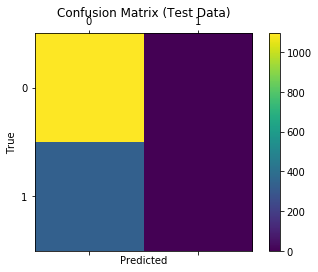

In [157]:
cm = confusion_matrix(test_target_values,test_data_pred,class_labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title("Confusion Matrix (Test Data)")
fig.colorbar(cax)
# ax.set_xticklabels(['']+class_labels)
# ax.set_yticklabels(['']+class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()